In [102]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

In [103]:
# Generate random keys for reproducibility
key = jr.key(42)
key_e, key_p = jr.split(key, 2)

## Warmup

In [104]:
a = jnp.ones((2,))
b = jnp.array([1.0, 2.0])
a + b

Array([2., 3.], dtype=float32)

## Linear regression

Linear function definition:

$$ f(p, x) : \mathbb{R}^2 \times \mathbb{R} \mapsto \mathbb{R} = p_1 x + p_2 $$

In [105]:
def f(p, x):
    y = p[0] * x  + p[1]
    return y

Apply function ``f`` with "true" parameter $p^o = [1.0\; 2.0]$ and $x=0.5$:

In [106]:
p_o = jnp.array([1.0, 2.0])
x = jnp.array(0.5)
y = f(p_o, x); y

Array(2.5, dtype=float32)

Apply function ``f`` with "true" parameter $p^o = [1.0\; 2.0]$ and 100 linearly spaced points in $[-2, 2]$. Add Gaussian noise with zero mean and standard deviation 0.1 to the output.

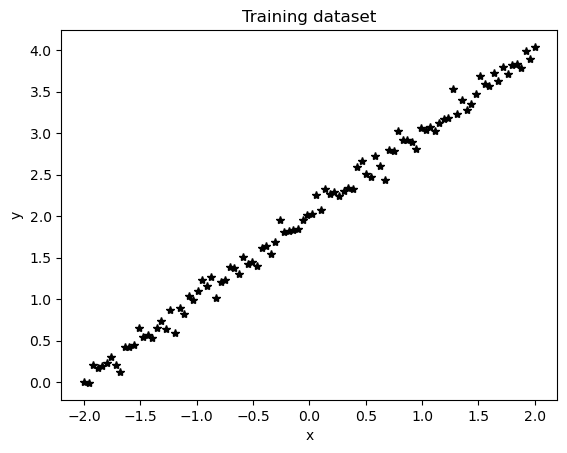

In [107]:
N = 100
x = jnp.linspace(-2, 2, N)
y = f(p_o, x) + jr.normal(key_e, (N,)) * 0.1

plt.plot(x, y, "k*", label="y")
plt.title("Training dataset")
plt.xlabel("x")
plt.ylabel("y");

Function `f` works correctly both with scalar and vector input `x`.

## Loss definition

The Mean Squared Error (MSE) loss is:
$$ {L}(p, y, x) : \mathbb{R}^{n_p} \times \mathbb{R}^N \times \mathbb{R}^N \mapsto \mathbb{R}
= \frac{1}{N}\sum_{i=1}^{N} \big(y_i - f(p, y_i, x_i)\big)^2
$$

In [108]:
def loss_fn(p, y, x):
    ym = f(p, x) # works both with scalar (data point) or vector (data batch) x
    loss = jnp.mean((y - ym) ** 2)
    return loss

In [109]:
p_hat = jax.random.normal(key_p, shape=(2,)); p_hat

Array([0.60576403, 0.7990441 ], dtype=float32)

In [110]:
loss_fn(p_hat, y, x)

Array(1.7047384, dtype=float32)

In [111]:
loss_fn(p_o, y, x) # loss close to 0.001 (std^2) at true parameters, as expected!

Array(0.00906244, dtype=float32)

## Automatic differentiation in Jax

Compute the gradient:

$$
\nabla_{1} {L}(p, y, x): \mathbb{R}^{n_p} \times \mathbb{R}^N \times \mathbb{R}^N \mapsto \mathbb{R}^{n_p},
$$
i.e. the derivative of ${L}$ with respect to its first argument: $p$.

In [112]:
# this defines the gradient function
grad_fn = jax.grad(loss_fn, 0) # gradient wrt 1st agrument

In [113]:
grad_fn(p_hat, y, x)

Array([-1.0732304, -2.4366264], dtype=float32)

In [114]:
grad_fn(p_o, y, x) # gradient close to 0 at true parameters, as it should!

Array([-0.00069623, -0.03471464], dtype=float32)

## Fitting a model with Jax

### Plain gradient descent by hand

In [115]:
p_init = p_hat

lr = 1e-2 # learning rate
L = []  # to store loss values
for i in range(200):
    loss = loss_fn(p_hat, y, x)
    L.append(loss)
    g = grad_fn(p_hat, y, x)
    p_hat = p_hat - lr * g 

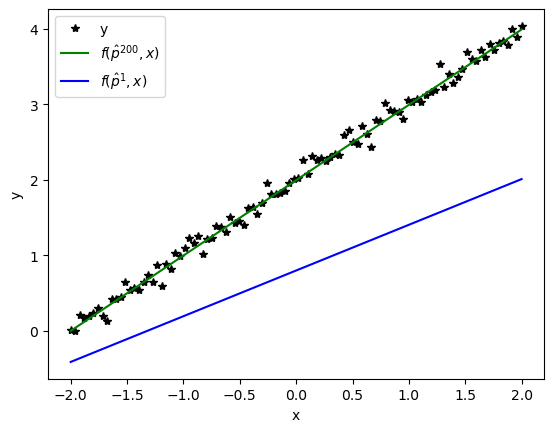

In [116]:
plt.figure()
plt.plot(x, y, "k*", label="y")
plt.plot(x, f(p_hat, x), "g", label=r"$f(\hat{p}^{200}, x)$")
plt.plot(x, f(p_init, x), "b", label=r"$f(\hat{p}^{1}, x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

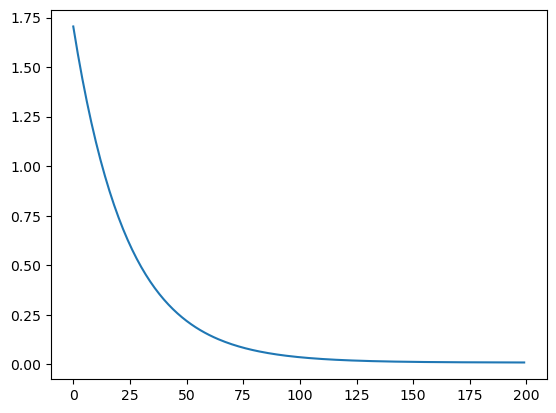

In [117]:
plt.figure()
plt.plot(jnp.array(L));

#### Verify that the learned parameters are close to the true ones

In [118]:
p_hat

Array([0.99867004, 1.9959298 ], dtype=float32)

#### Verify that the gradient returned by Jax is correct

In [119]:
grad_fn(p_init, y, x) # do you trust Jax?

Array([-1.0732304, -2.4366264], dtype=float32)

We need to re-write model and loss in matrix form:
$$ y = \overbrace{\begin{bmatrix}x_1 & 1\\ x_2 & 1 \\ \dots\\ x_N & 1 \end{bmatrix}}^{=\Phi} \theta, \qquad 
L(\theta) = \frac{1}{N}(y-\Phi \theta)^\top (y-\Phi \theta)$$

Then:
$$ \nabla{L(\theta)} = \frac{2}{N} \Phi^\top(\Phi \theta - y)$$

In [120]:
PHI = jnp.vstack([x, jnp.ones_like(x)]).T   
2 / N * PHI.T @ (PHI @ p_init - y)

Array([-1.0732305, -2.4366264], dtype=float32)

Practitioners would not trust their linear algebra skill and check against finite differences!

In [121]:
eps = 1e-5

In [122]:
(loss_fn(p_init + jnp.array([eps, 0.0]), y, x) - loss_fn(p_init, y, x)) / eps

Array(-1.0490417, dtype=float32)

In [123]:
(loss_fn(p_init + jnp.array([0, eps]), y, x) - loss_fn(p_init, y, x)) / eps

Array(-2.4318695, dtype=float32)